In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

# 1. Cleaning the Data

In [2]:
data = pd.read_csv('DataCognitive_Task2.csv',dtype={'sbj': str})
data = data.drop(columns=['Unnamed: 0'])
data.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,size
0,8101004202,50.bmp,3.825690,p,1.0,r,r,r,m,22.0,2.0,NaN
1,8101004202,60.bmp,2.733858,p,7.0,r,r,r,m,22.0,2.0,NaN
2,8101004202,60.bmp,1.618684,p,2.0,r,r,r,m,22.0,2.0,NaN
3,8101004202,50.bmp,0.925664,o,10.0,r,r,r,m,22.0,2.0,NaN
4,8101004202,30.bmp,3.540292,o,7.0,r,r,r,m,22.0,2.0,NaN


In [3]:
ml_sec_indexes = data[ (data['sbj'] =='8101003761') | (data['sbj'] =='8101003762')].index
data.loc[ml_sec_indexes,'rt'] = data.loc[ml_sec_indexes,'rt'] / 1000

In [4]:
data.isna().sum()

sbj           4
stm          15
rt           12
key          15
pos        1770
uhnd         16
hndns         4
eye           5
sex           4
age           4
edu           7
size     116079
dtype: int64

In [5]:
data = data.drop(data[data.sbj.isna()].index)
data = data.drop(data[data.stm.isna()].index)
data = data.drop(data[~data.sbj.str.contains('810')].index)
data.loc[data[data.uhnd.isna()].index, 'uhnd'] = 'r'
data.loc[data[data.eye.isna()].index, 'eye'] = 'l'
data = data.drop(data[data.pos.isna()].index)
data  = data.drop(columns=['size'])
data.isna().sum()

sbj      0
stm      0
rt       0
key      0
pos      0
uhnd     0
hndns    0
eye      0
sex      0
age      0
edu      0
dtype: int64

In [6]:
path_index = data[data.stm.str.contains('Supplementary Material/')].index
data.loc[path_index,'stm'] = data.loc[path_index,'stm'].apply(lambda x: x.split('/')[1])

In [7]:
pos_index = data[data.sbj.isin(data[data.pos == 0].sbj.unique())].index
data.loc[pos_index, 'pos'] += 1

In [8]:
data.uhnd.unique()

array(['r', 'l', 'I', '0.bmp', '10.bmp'], dtype=object)

In [9]:
data.loc[data[data.uhnd == 'I'].index, 'uhnd'] = 'l'

In [10]:
uhnd_index = data[data.uhnd.isin(['0.bmp','10.bmp'])].index
data.loc[uhnd_index,'uhnd'] = data.loc[uhnd_index,'key'].apply(lambda x: 'l' if (x == 'w') or (x == 'q') else 'r')

In [11]:
data.uhnd.unique()

array(['r', 'l'], dtype=object)

In [12]:
data.edu.unique()

array([2., 4., 3., 1.])

In [13]:
# Select the first quantile
q1 = data['rt'].quantile(.25)

# Select the third quantile
q3 = data['rt'].quantile(.75)

# Create a mask inbeetween q1 & q3
mask = data['rt'].between(0.1, q3 + 1.5 * (q3-q1), inclusive='both')


In [14]:

# Filtering the initial dataframe with a mask
clean_data = data.loc[mask, :]

In [15]:
clean_data.shape

(110294, 11)

# 2. Exploring the Data

In [16]:
clean_data['rt'] *= 1000
clean_data['lrt'] = np.log(clean_data.rt)

<ipython-input-16-bb8efcecc9f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['rt'] *= 1000
<ipython-input-16-bb8efcecc9f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['lrt'] = np.log(clean_data.rt)


In [17]:
data4 = clean_data

In [18]:
nutral_index = clean_data[clean_data.stm == '40.bmp'].index
clean_data = clean_data.drop(nutral_index)

In [19]:
male_stm = ['0.bmp', '10.bmp', '20.bmp', '30.bmp']
female_stm = ['50.bmp', '60.bmp', '70.bmp', '80.bmp']

condition = lambda x: 1 if ((x.key == 'q' or x.key =='o') and (x.stm in female_stm)) or ((x.key == 'w' or x.key =='p') and (x.stm in male_stm)) else 0
clean_data['acc'] = clean_data.loc[:, ['stm','key']].apply( condition, axis=1)

In [20]:
clean_data['ecc'] = 0
clean_data.loc[((clean_data.pos< 8) & (clean_data.pos >1)), 'ecc'] = 1
clean_data.loc[((clean_data.pos< 14) & (clean_data.pos >7)), 'ecc'] = 2

In [21]:
clean_data['vf'] = 0
clean_data.loc[(clean_data.pos.isin([2, 8, 13])), 'vf'] = 1
clean_data.loc[(clean_data.pos.isin([3, 4, 9])), 'vf'] = 2
clean_data.loc[(clean_data.pos.isin([5, 10, 11])), 'vf'] = 3
clean_data.loc[(clean_data.pos.isin([6, 7, 12])), 'vf'] = 4

In [22]:
clean_data['udhnd'] = clean_data[['uhnd','hndns']].apply(lambda x: 1 if x.uhnd == x.hndns else 0, axis=1)

In [23]:
clean_data = clean_data.reset_index(drop=True)
clean_data.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,lrt,acc,ecc,vf,udhnd
0,8101004202,50.bmp,925.6644,o,10.0,r,r,r,m,22.0,2.0,6.830512,1,2,3,1
1,8101004202,70.bmp,1163.9952,o,6.0,r,r,r,m,22.0,2.0,7.059614,1,1,4,1
2,8101004202,50.bmp,1023.1118,o,9.0,r,r,r,m,22.0,2.0,6.930604,1,2,2,1
3,8101004202,80.bmp,970.4250,o,10.0,r,r,r,m,22.0,2.0,6.877734,1,2,3,1
4,8101004202,60.bmp,1175.1443,p,13.0,r,r,r,m,22.0,2.0,7.069146,0,2,1,1


In [24]:
independent_vars = ['pos', 'ecc', 'vf', 'uhnd','udhnd', 'sex', 'hndns', 'eye']

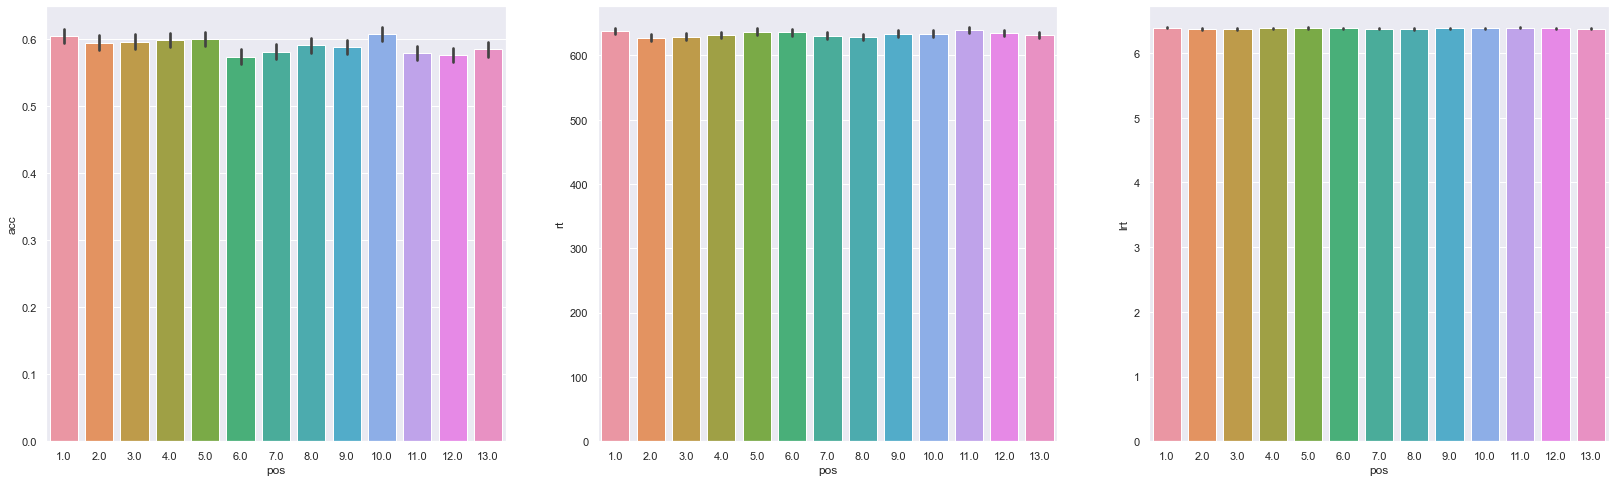

In [25]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[0]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data,  estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [26]:
model1 = ols('rt ~ pos', data=clean_data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8821
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.348
Time:                        17:16:45   Log-Likelihood:            -6.6795e+05
No. Observations:               98157   AIC:                         1.336e+06
Df Residuals:                   98155   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    632.1928      1.480    427.265      0.000     629.293     635.093
pos            0.1751      0.186      0.939      0.348      -0.190       0.540
==============================================================================
Omnibus:                     1190.104   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1235.868
Skew:                           0.269   Prob(JB):                    4.31e-269
Kurtosis:                       3.116   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
model1 = ols('lrt ~ pos', data=clean_data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2608
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.610
Time:                        17:16:45   Log-Likelihood:                -49604.
No. Observations:               98157   AIC:                         9.921e+04
Df Residuals:                   98155   BIC:                         9.923e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3799      0.003   2347.099      0.000       6.375       6.385
pos            0.0002      0.000      0.511      0.610      -0.000       0.001
==============================================================================
Omnibus:                    21123.523   Durbin-Watson:                   0.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51624.605
Skew:                          -1.196   Prob(JB):                         0.00
Kurtosis:                       5.628   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
model1 = smf.logit('acc ~ pos', data=clean_data).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.676421
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               8.220e-05
Time:                        17:16:45   Log-Likelihood:                -66395.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                 0.0009531
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4085      0.014     29.584      0.000       0.381       0.436
pos           -0.0057      0.002     -3.304      0.001      -0.009      -0.002
==============================================================================
"""

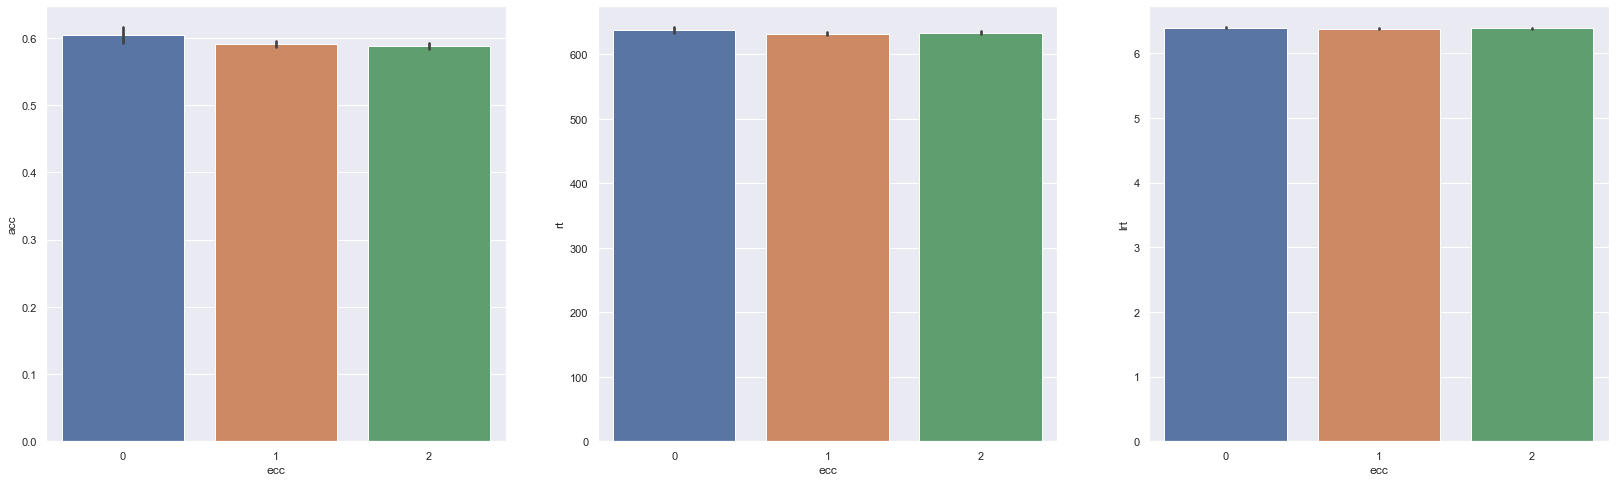

In [29]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[1]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data,  estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [30]:
model2 = ols('rt ~ ecc', data=clean_data).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1145
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.735
Time:                        17:16:51   Log-Likelihood:            -6.6795e+05
No. Observations:               98157   AIC:                         1.336e+06
Df Residuals:                   98155   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    633.9419      1.696    373.772      0.000     630.618     637.266
ecc           -0.3777      1.116     -0.338      0.735      -2.565       1.810
==============================================================================
Omnibus:                     1191.102   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1236.949
Skew:                           0.269   Prob(JB):                    2.51e-269
Kurtosis:                       3.116   Cond. No.                         5.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model2 = ols('lrt ~ ecc', data=clean_data).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4946
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.482
Time:                        17:16:51   Log-Likelihood:                -49604.
No. Observations:               98157   AIC:                         9.921e+04
Df Residuals:                   98155   BIC:                         9.923e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3831      0.003   2048.627      0.000       6.377       6.389
ecc           -0.0014      0.002     -0.703      0.482      -0.005       0.003
==============================================================================
Omnibus:                    21122.774   Durbin-Watson:                   0.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51624.905
Skew:                          -1.196   Prob(JB):                         0.00
Kurtosis:                       5.628   Cond. No.                         5.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
model2 = smf.logit('acc ~ ecc', data=clean_data).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.676451
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               3.839e-05
Time:                        17:16:52   Log-Likelihood:                -66398.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                   0.02395
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4008      0.016     25.327      0.000       0.370       0.432
ecc           -0.0235      0.010     -2.257      0.024      -0.044      -0.003
==============================================================================
"""

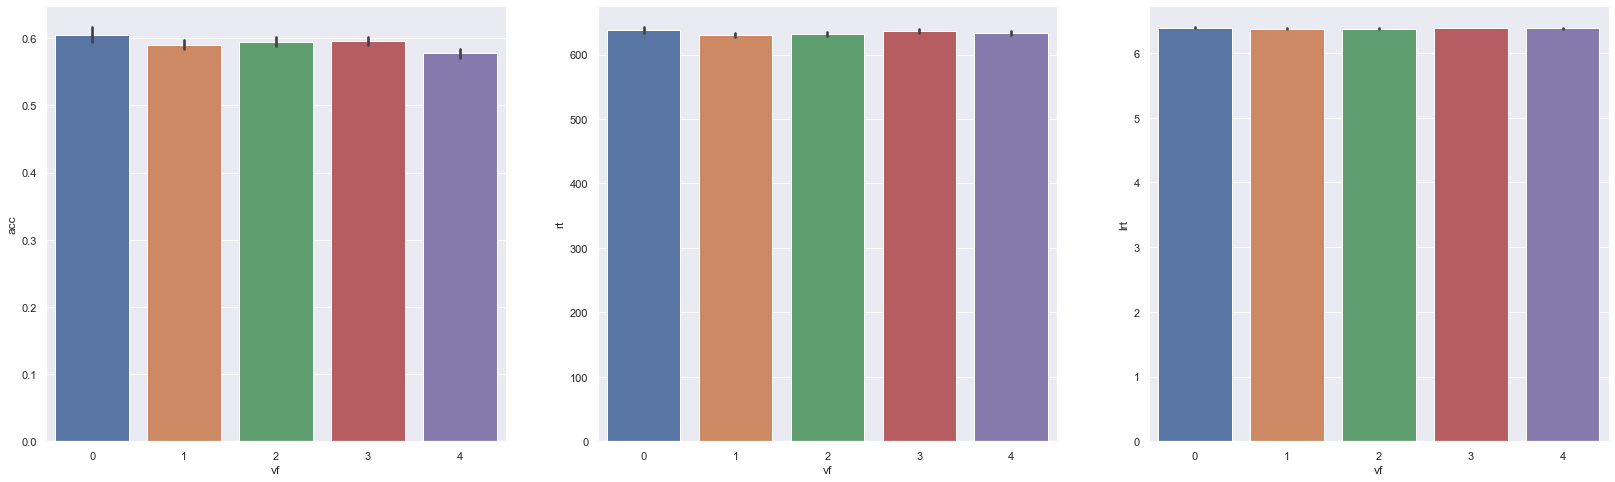

In [33]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[2]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data,  estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [34]:
model3 = ols('rt ~ vf', data=clean_data).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.701
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.192
Time:                        17:16:57   Log-Likelihood:            -6.6795e+05
No. Observations:               98157   AIC:                         1.336e+06
Df Residuals:                   98155   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    631.7555      1.453    434.765      0.000     628.907     634.604
vf             0.7199      0.552      1.304      0.192      -0.362       1.802
==============================================================================
Omnibus:                     1190.062   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1235.842
Skew:                           0.269   Prob(JB):                    4.37e-269
Kurtosis:                       3.116   Cond. No.                         6.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
model3 = ols('lrt ~ vf', data=clean_data).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3681
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.544
Time:                        17:16:58   Log-Likelihood:                -49604.
No. Observations:               98157   AIC:                         9.921e+04
Df Residuals:                   98155   BIC:                         9.923e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3797      0.003   2389.872      0.000       6.374       6.385
vf             0.0006      0.001      0.607      0.544      -0.001       0.003
==============================================================================
Omnibus:                    21124.884   Durbin-Watson:                   0.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51631.516
Skew:                          -1.196   Prob(JB):                         0.00
Kurtosis:                       5.628   Cond. No.                         6.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
model3 = smf.logit('acc ~ vf', data=clean_data).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.676414
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               9.231e-05
Time:                        17:16:58   Log-Likelihood:                -66395.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                 0.0004630
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4099      0.014     30.218      0.000       0.383       0.437
vf            -0.0180      0.005     -3.501      0.000      -0.028      -0.008
==============================================================================
"""

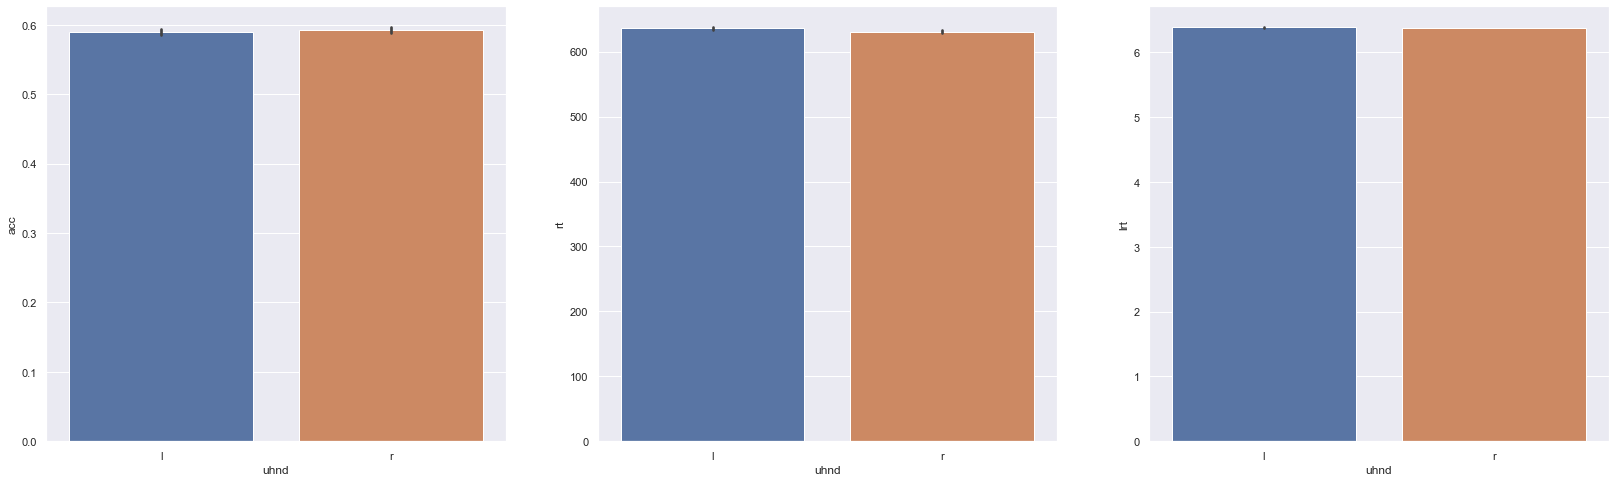

In [37]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[3]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data, order = ['l', 'r'],  estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [38]:
model4 = ols('rt ~ uhnd ', data=clean_data).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     12.38
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           0.000433
Time:                        17:17:04   Log-Likelihood:            -6.6795e+05
No. Observations:               98157   AIC:                         1.336e+06
Df Residuals:                   98155   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    635.8699      0.985    645.379      0.000     633.939     637.801
uhnd[T.r]     -4.9045      1.394     -3.519      0.000      -7.636      -2.173
==============================================================================
Omnibus:                     1193.242   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1239.276
Skew:                           0.269   Prob(JB):                    7.84e-270
Kurtosis:                       3.116   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
model4 = ols('lrt ~ uhnd', data=clean_data).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.41
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           5.10e-05
Time:                        17:17:05   Log-Likelihood:                -49596.
No. Observations:               98157   AIC:                         9.920e+04
Df Residuals:                   98155   BIC:                         9.922e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3863      0.002   3528.389      0.000       6.383       6.390
uhnd[T.r]     -0.0104      0.003     -4.051      0.000      -0.015      -0.005
==============================================================================
Omnibus:                    21104.673   Durbin-Watson:                   0.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51531.932
Skew:                          -1.195   Prob(JB):                         0.00
Kurtosis:                       5.624   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
model4 = smf.logit('acc ~ uhnd', data=clean_data).fit()
model4.summary()

Optimization terminated successfully.
         Current function value: 0.676474
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               4.728e-06
Time:                        17:17:06   Log-Likelihood:                -66401.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                    0.4281
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3631      0.009     39.578      0.000       0.345       0.381
uhnd[T.r]      0.0103      0.013      0.792      0.428      -0.015       0.036
==============================================================================
"""

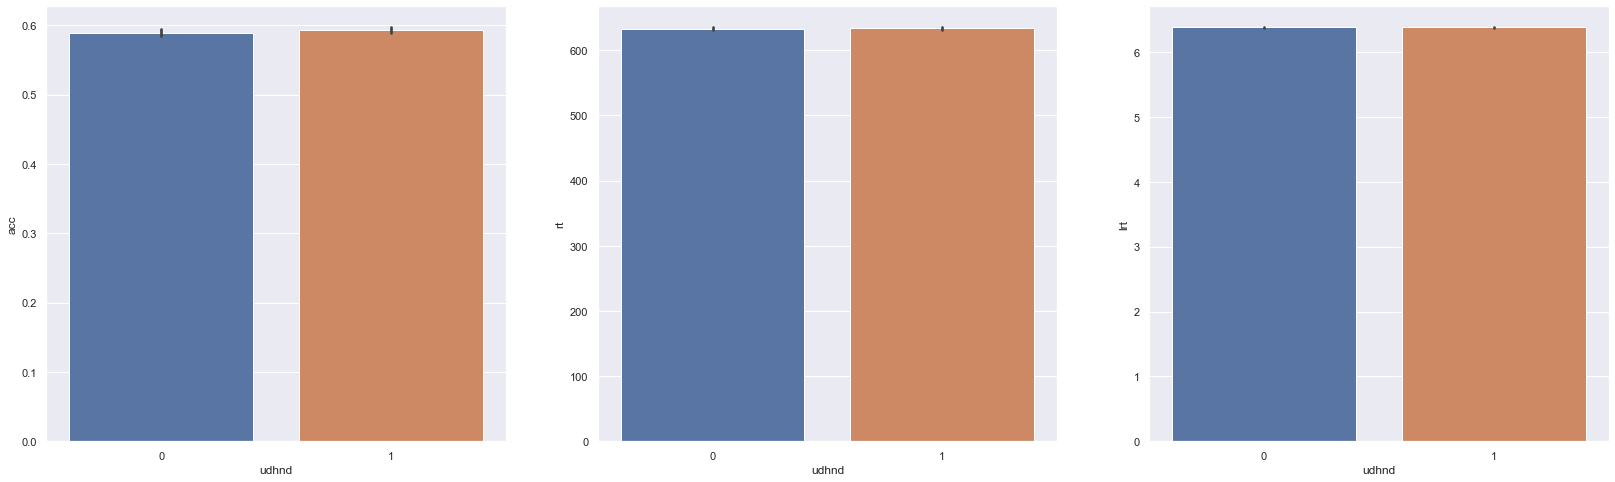

In [41]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[4]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data,  estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [42]:
model5 = ols('rt ~ udhnd', data=clean_data).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01663
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.897
Time:                        17:17:11   Log-Likelihood:            -6.6795e+05
No. Observations:               98157   AIC:                         1.336e+06
Df Residuals:                   98155   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    633.3288      0.985    642.713      0.000     631.397     635.260
udhnd          0.1797      1.394      0.129      0.897      -2.552       2.911
==============================================================================
Omnibus:                     1190.792   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1236.615
Skew:                           0.269   Prob(JB):                    2.97e-269
Kurtosis:                       3.116   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
model5 = ols('lrt ~ udhnd', data=clean_data).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5021
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.479
Time:                        17:17:11   Log-Likelihood:                -49604.
No. Observations:               98157   AIC:                         9.921e+04
Df Residuals:                   98155   BIC:                         9.923e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3820      0.002   3525.489      0.000       6.378       6.386
udhnd         -0.0018      0.003     -0.709      0.479      -0.007       0.003
==============================================================================
Omnibus:                    21118.709   Durbin-Watson:                   0.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51601.011
Skew:                          -1.195   Prob(JB):                         0.00
Kurtosis:                       5.627   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
model5 = smf.logit('acc ~ udhnd', data=clean_data).fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 0.676471
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               9.148e-06
Time:                        17:17:11   Log-Likelihood:                -66400.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                    0.2704
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3611      0.009     39.363      0.000       0.343       0.379
udhnd          0.0143      0.013      1.102      0.270      -0.011       0.040
==============================================================================
"""

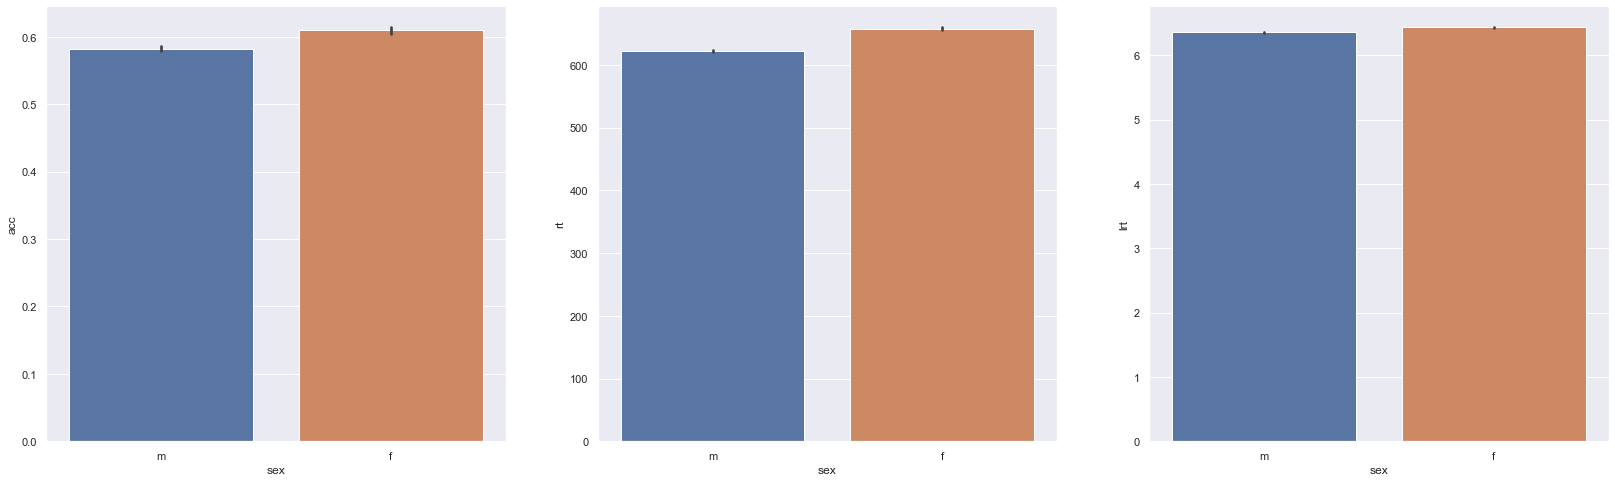

In [45]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[5]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data,  estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [46]:
model6 = ols('rt ~ sex', data=clean_data).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     605.9
Date:                Thu, 07 Apr 2022   Prob (F-statistic):          2.26e-133
Time:                        17:17:18   Log-Likelihood:            -6.6765e+05
No. Observations:               98157   AIC:                         1.335e+06
Df Residuals:                   98155   BIC:                         1.335e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    657.6270      1.204    546.140      0.000     655.267     659.987
sex[T.m]     -36.2876      1.474    -24.614      0.000     -39.177     -33.398
==============================================================================
Omnibus:                     1338.760   Durbin-Watson:                   0.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1395.948
Skew:                           0.286   Prob(JB):                    7.48e-304
Kurtosis:                       3.118   Cond. No.                         3.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
model6 = ols('lrt ~ sex', data=clean_data).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     828.8
Date:                Thu, 07 Apr 2022   Prob (F-statistic):          1.72e-181
Time:                        17:17:19   Log-Likelihood:                -49192.
No. Observations:               98157   AIC:                         9.839e+04
Df Residuals:                   98155   BIC:                         9.841e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4331      0.002   2911.416      0.000       6.429       6.437
sex[T.m]      -0.0779      0.003    -28.788      0.000      -0.083      -0.073
==============================================================================
Omnibus:                    20430.922   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48886.796
Skew:                          -1.167   Prob(JB):                         0.00
Kurtosis:                       5.551   Cond. No.                         3.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
model6 = smf.logit('acc ~ sex', data=clean_data).fit()
model6.summary()

Optimization terminated successfully.
         Current function value: 0.676132
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               0.0005094
Time:                        17:17:19   Log-Likelihood:                -66367.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                 1.955e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4443      0.011     39.188      0.000       0.422       0.467
sex[T.m]      -0.1136      0.014     -8.213      0.000      -0.141      -0.086
==============================================================================
"""

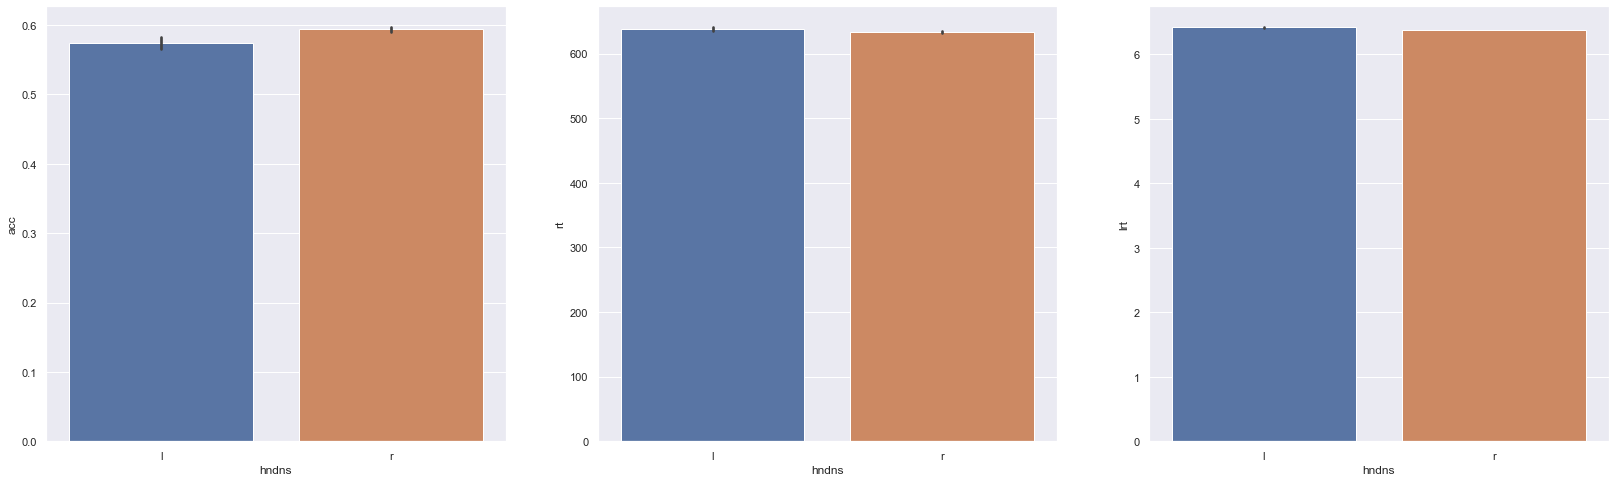

In [49]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[6]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data, order = ['l', 'r'],  estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [50]:
model7 = ols('rt ~ hndns', data=clean_data).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.265
Date:                Thu, 07 Apr 2022   Prob (F-statistic):             0.0123
Time:                        17:17:27   Log-Likelihood:            -6.6795e+05
No. Observations:               98157   AIC:                         1.336e+06
Df Residuals:                   98155   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    637.9296      1.932    330.155      0.000     634.142     641.717
hndns[T.r]    -5.1854      2.072     -2.503      0.012      -9.246      -1.125
==============================================================================
Omnibus:                     1209.549   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1256.583
Skew:                           0.271   Prob(JB):                    1.37e-273
Kurtosis:                       3.114   Cond. No.                         5.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
model7 = ols('lrt ~ hndns', data=clean_data).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     105.1
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           1.21e-24
Time:                        17:17:28   Log-Likelihood:                -49552.
No. Observations:               98157   AIC:                         9.911e+04
Df Residuals:                   98155   BIC:                         9.913e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4150      0.004   1808.151      0.000       6.408       6.422
hndns[T.r]    -0.0390      0.004    -10.251      0.000      -0.046      -0.032
==============================================================================
Omnibus:                    20741.358   Durbin-Watson:                   0.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50009.222
Skew:                          -1.180   Prob(JB):                         0.00
Kurtosis:                       5.580   Cond. No.                         5.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
model7 = smf.logit('acc ~ hndns', data=clean_data).fit()
model7.summary()

Optimization terminated successfully.
         Current function value: 0.676385
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               0.0001351
Time:                        17:17:29   Log-Likelihood:                -66392.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                 2.278e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2975      0.018     16.621      0.000       0.262       0.333
hndns[T.r]     0.0815      0.019      4.242      0.000       0.044       0.119
==============================================================================
"""

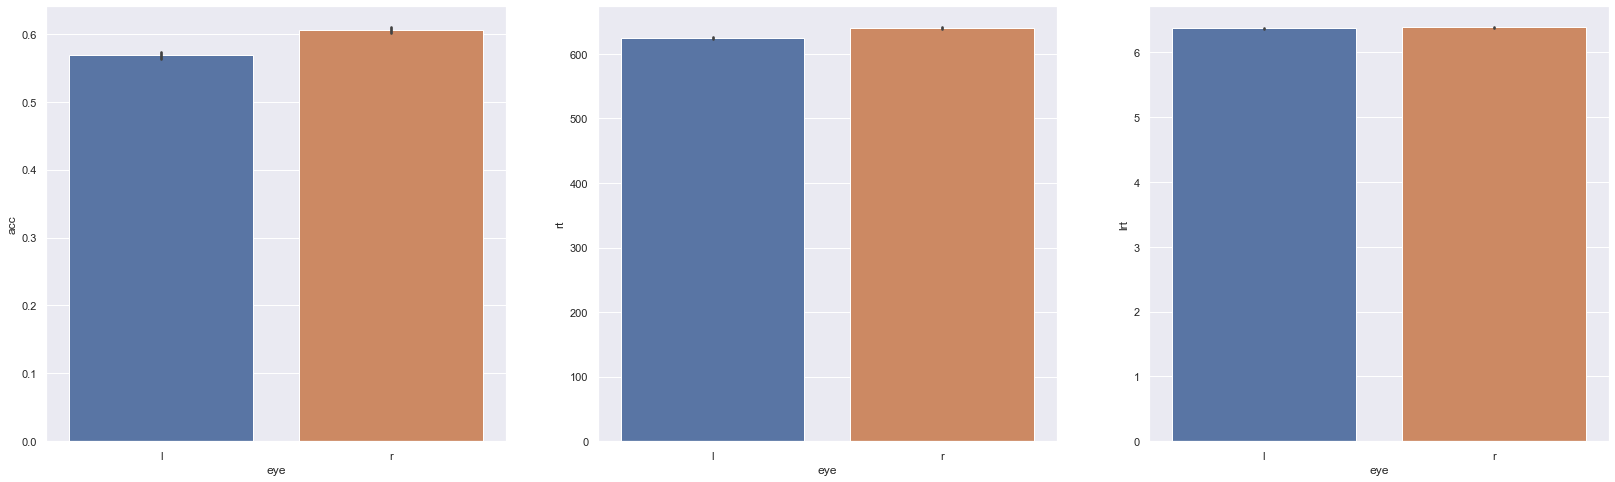

In [53]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
counter = 0
dep_cols = ['acc', 'rt', 'lrt']
indep_cols = [independent_vars[7]]
subs = [0, 1, 2]
for i in range(len(indep_cols)):
    for j in range(len(dep_cols)):
        ax = sns.barplot(ax = axes[subs[counter]], x=indep_cols[i], y=dep_cols[j], data=clean_data, order = ['l', 'r'], estimator=np.mean, ci = 95)
        counter +=1
plt.show()

In [54]:
model8 = ols('rt ~ eye', data=clean_data).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     111.8
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           4.01e-26
Time:                        17:17:36   Log-Likelihood:            -6.6790e+05
No. Observations:               98157   AIC:                         1.336e+06
Df Residuals:                   98155   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    624.3436      1.105    564.910      0.000     622.177     626.510
eye[T.r]      15.0527      1.423     10.575      0.000      12.263      17.843
==============================================================================
Omnibus:                     1198.355   Durbin-Watson:                   0.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1246.517
Skew:                           0.268   Prob(JB):                    2.10e-271
Kurtosis:                       3.133   Cond. No.                         2.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
model8 = ols('lrt ~ eye', data=clean_data).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     40.84
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           1.66e-10
Time:                        17:17:37   Log-Likelihood:                -49584.
No. Observations:               98157   AIC:                         9.917e+04
Df Residuals:                   98155   BIC:                         9.919e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3710      0.002   3136.754      0.000       6.367       6.375
eye[T.r]       0.0167      0.003      6.390      0.000       0.012       0.022
==============================================================================
Omnibus:                    21325.571   Durbin-Watson:                   0.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52726.875
Skew:                          -1.202   Prob(JB):                         0.00
Kurtosis:                       5.667   Cond. No.                         2.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
model8 = smf.logit('acc ~ eye', data=clean_data).fit()
model8.summary()

Optimization terminated successfully.
         Current function value: 0.675777
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98155
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:                0.001034
Time:                        17:17:38   Log-Likelihood:                -66332.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                 1.035e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2752      0.010     26.911      0.000       0.255       0.295
eye[T.r]       0.1552      0.013     11.724      0.000       0.129       0.181
==============================================================================
"""

# 3. Prediction of Behavioral Characteristics

In [57]:
clean_data.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,lrt,acc,ecc,vf,udhnd
0,8101004202,50.bmp,925.6644,o,10.0,r,r,r,m,22.0,2.0,6.830512,1,2,3,1
1,8101004202,70.bmp,1163.9952,o,6.0,r,r,r,m,22.0,2.0,7.059614,1,1,4,1
2,8101004202,50.bmp,1023.1118,o,9.0,r,r,r,m,22.0,2.0,6.930604,1,2,2,1
3,8101004202,80.bmp,970.4250,o,10.0,r,r,r,m,22.0,2.0,6.877734,1,2,3,1
4,8101004202,60.bmp,1175.1443,p,13.0,r,r,r,m,22.0,2.0,7.069146,0,2,1,1


In [58]:
clean_data2 = clean_data.replace({'uhnd':{'r':0, 'l':1}, 'hndns':{'r':0, 'l':1}, 'eye':{'r':0, 'l':1}, 'sex':{'m':0, 'f':1} })
clean_data2.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,lrt,acc,ecc,vf,udhnd
0,8101004202,50.bmp,925.6644,o,10.0,0,0,0,0,22.0,2.0,6.830512,1,2,3,1
1,8101004202,70.bmp,1163.9952,o,6.0,0,0,0,0,22.0,2.0,7.059614,1,1,4,1
2,8101004202,50.bmp,1023.1118,o,9.0,0,0,0,0,22.0,2.0,6.930604,1,2,2,1
3,8101004202,80.bmp,970.4250,o,10.0,0,0,0,0,22.0,2.0,6.877734,1,2,3,1
4,8101004202,60.bmp,1175.1443,p,13.0,0,0,0,0,22.0,2.0,7.069146,0,2,1,1


In [59]:
model_rt = ols('''rt ~ uhnd + sex + hndns + eye 
                + uhnd * sex + uhnd*hndns + uhnd*eye
                + sex * hndns + sex * eye
                + hndns*eye''', data=clean_data2).fit()
model_rt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     109.3
Date:                Thu, 07 Apr 2022   Prob (F-statistic):          5.83e-205
Time:                        17:17:39   Log-Likelihood:            -6.6746e+05
No. Observations:               98157   AIC:                         1.335e+06
Df Residuals:                   98147   BIC:                         1.335e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    621.1195      1.555    399.507      0.000     618.072     624.167
uhnd           7.4097      2.110      3.512      0.000       3.275      11.545
sex           51.3779      2.500     20.548      0.000      46.477      56.279
hndns          9.2128      3.964      2.324      0.020       1.443      16.983
eye          -25.4180      2.488    -10.216      0.000     -30.295     -20.542
uhnd:sex     -16.9594      3.076     -5.514      0.000     -22.988     -10.931
uhnd:hndns     9.4463      4.371      2.161      0.031       0.880      18.013
uhnd:eye       4.3529      2.894      1.504      0.133      -1.320      10.025
sex:hndns  -9.855e-14   1.45e-14     -6.808      0.000   -1.27e-13   -7.02e-14
sex:eye       -0.0679      3.160     -0.021      0.983      -6.262       6.127
hndns:eye     21.8798      4.446      4.922      0.000      13.166      30.593
==============================================================================
Omnibus:                     1476.235   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1546.610
Skew:                           0.300   Prob(JB):                         0.00
Kurtosis:                       3.134   Cond. No.                     1.25e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [60]:
model_rt = ols('''rt ~ uhnd + sex + hndns + eye 
                + uhnd * sex + uhnd*hndns
                + sex * eye -1''', data=clean_data2).fit()
model_rt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     rt   R-squared (uncentered):                   0.701
Model:                            OLS   Adj. R-squared (uncentered):              0.701
Method:                 Least Squares   F-statistic:                          3.285e+04
Date:                Thu, 07 Apr 2022   Prob (F-statistic):                        0.00
Time:                        17:17:40   Log-Likelihood:                     -7.1878e+05
No. Observations:               98157   AIC:                                  1.438e+06
Df Residuals:                   98150   BIC:                                  1.438e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
uhnd         529.0818      2.436    217.152      0.000     524.306     533.857
sex          671.5469      3.382    198.567      0.000     664.918     678.176
hndns        452.3944      4.899     92.346      0.000     442.793     461.996
eye          285.5485      2.791    102.306      0.000     280.078     291.019
uhnd:sex    -536.7527      4.730   -113.468      0.000    -546.024    -527.481
uhnd:hndns  -511.0932      6.927    -73.784      0.000    -524.670    -497.517
sex:eye     -308.8432      4.954    -62.340      0.000    -318.553    -299.133
==============================================================================
Omnibus:                     4355.488   Durbin-Watson:                   0.336
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4963.212
Skew:                           0.550   Prob(JB):                         0.00
Kurtosis:                       2.955   Cond. No.                         6.59
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

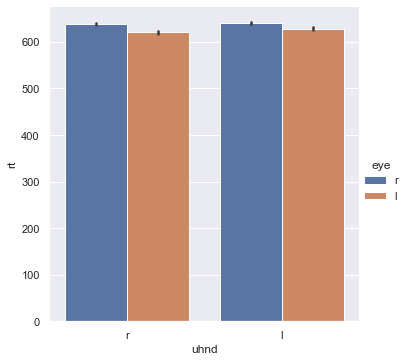

In [61]:
sns.catplot(x="uhnd", y="rt", hue="eye", data=clean_data, kind="bar")


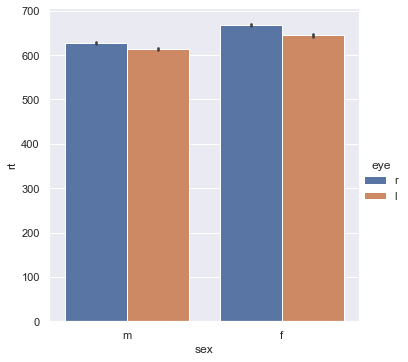

In [62]:
sns.catplot(x="sex", y="rt", hue="eye", data=clean_data, kind="bar")

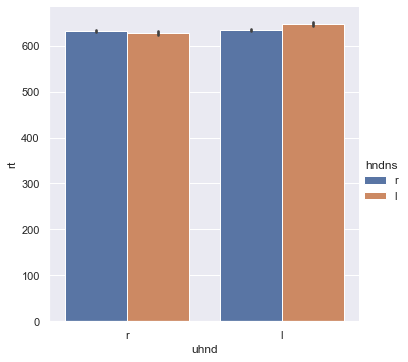

In [63]:
sns.catplot(x="uhnd", y="rt", hue="hndns", data=clean_data, kind="bar")

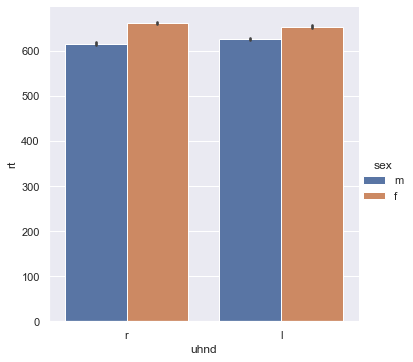

In [64]:
sns.catplot(x="uhnd", y="rt", hue="sex", data=clean_data, kind="bar")

In [65]:
model_lrt = ols('''lrt ~ uhnd + sex + hndns + eye 
                + uhnd * sex + uhnd*hndns + uhnd*eye
                + sex * hndns + sex * eye
                + hndns*eye''', data=clean_data2).fit()
model_lrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lrt   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     159.1
Date:                Thu, 07 Apr 2022   Prob (F-statistic):          1.86e-300
Time:                        17:17:51   Log-Likelihood:                -48894.
No. Observations:               98157   AIC:                         9.781e+04
Df Residuals:                   98147   BIC:                         9.790e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3389      0.003   2224.404      0.000       6.333       6.344
uhnd           0.0192      0.004      4.964      0.000       0.012       0.027
sex            0.1248      0.005     27.237      0.000       0.116       0.134
hndns          0.0682      0.007      9.390      0.000       0.054       0.082
eye           -0.0264      0.005     -5.782      0.000      -0.035      -0.017
uhnd:sex      -0.0376      0.006     -6.676      0.000      -0.049      -0.027
uhnd:hndns     0.0109      0.008      1.362      0.173      -0.005       0.027
uhnd:eye       0.0046      0.005      0.858      0.391      -0.006       0.015
sex:hndns  -1.609e-16   2.65e-17     -6.065      0.000   -2.13e-16   -1.09e-16
sex:eye       -0.0254      0.006     -4.388      0.000      -0.037      -0.014
hndns:eye      0.0125      0.008      1.534      0.125      -0.003       0.028
==============================================================================
Omnibus:                    19748.791   Durbin-Watson:                   0.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46645.648
Skew:                          -1.135   Prob(JB):                         0.00
Kurtosis:                       5.501   Cond. No.                     1.25e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [66]:
model_lrt = ols('''lrt ~ uhnd + sex + hndns + eye 
                + uhnd * sex 
                + sex * hndns + sex * eye
                + hndns*eye -1''', data=clean_data2).fit()
model_lrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    lrt   R-squared (uncentered):                   0.764
Model:                            OLS   Adj. R-squared (uncentered):              0.764
Method:                 Least Squares   F-statistic:                          4.528e+04
Date:                Thu, 07 Apr 2022   Prob (F-statistic):                        0.00
Time:                        17:17:52   Log-Likelihood:                     -2.5062e+05
No. Observations:               98157   AIC:                                  5.013e+05
Df Residuals:                   98150   BIC:                                  5.013e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
uhnd           4.4874      0.020    228.981      0.000       4.449       4.526
sex            6.4627      0.029    225.228      0.000       6.406       6.519
hndns          4.1931      0.046     91.983      0.000       4.104       4.282
eye            4.0756      0.026    157.975      0.000       4.025       4.126
uhnd:sex      -4.5039      0.040   -113.757      0.000      -4.581      -4.426
sex:hndns   -7.55e-15    5.7e-17   -132.511      0.000   -7.66e-15   -7.44e-15
sex:eye       -4.1251      0.043    -95.351      0.000      -4.210      -4.040
hndns:eye     -4.1128      0.062    -66.100      0.000      -4.235      -3.991
==============================================================================
Omnibus:                     6610.650   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6781.638
Skew:                           0.600   Prob(JB):                         0.00
Kurtosis:                       2.535   Cond. No.                     2.05e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.14e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

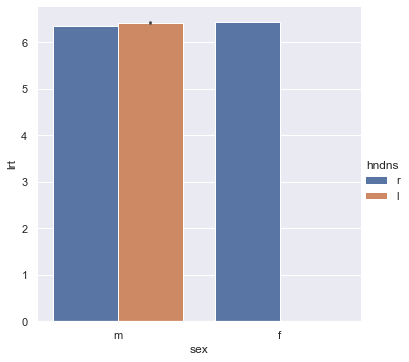

In [67]:
sns.catplot(x="sex", y="lrt", hue="hndns", data=clean_data, kind="bar")

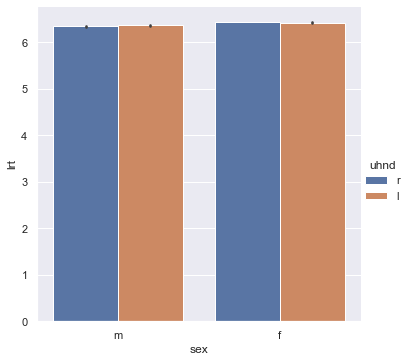

In [68]:
sns.catplot(x="sex", y="lrt", hue="uhnd", data=clean_data, kind="bar")

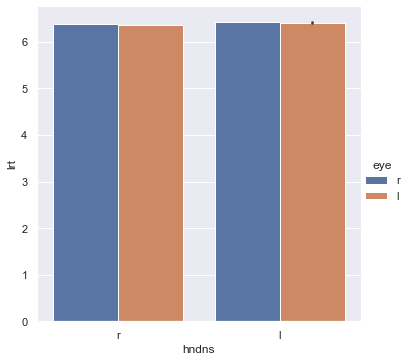

In [69]:
sns.catplot(x="hndns", y="lrt", hue="eye", data=clean_data, kind="bar")

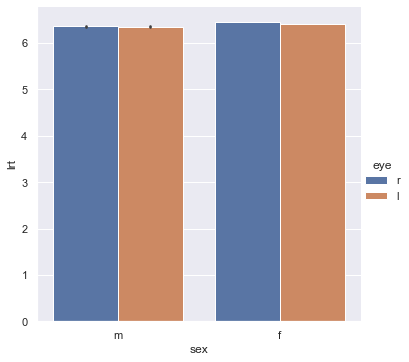

In [70]:
sns.catplot(x="sex", y="lrt", hue="eye", data=clean_data, kind="bar")

In [71]:
model_acc = smf.logit('''acc ~ pos + vf + sex  + eye      
                + sex * eye
                + hndns*eye -1''', data=clean_data2).fit()
model_acc.summary()

Optimization terminated successfully.
         Current function value: 0.677437
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    acc   No. Observations:                98157
Model:                          Logit   Df Residuals:                    98150
Method:                           MLE   Df Model:                            6
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:               -0.001420
Time:                        17:18:02   Log-Likelihood:                -66495.
converged:                       True   LL-Null:                       -66401.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pos            0.0168      0.002     10.100      0.000       0.014       0.020
vf             0.0449      0.005      9.000      0.000       0.035       0.055
sex            0.3843      0.018     21.891      0.000       0.350       0.419
eye            0.0445      0.018      2.512      0.012       0.010       0.079
sex:eye       -0.4076      0.029    -14.091      0.000      -0.464      -0.351
hndns         -0.0186      0.030     -0.619      0.536      -0.078       0.040
hndns:eye      0.1111      0.041      2.721      0.007       0.031       0.191
==============================================================================
"""

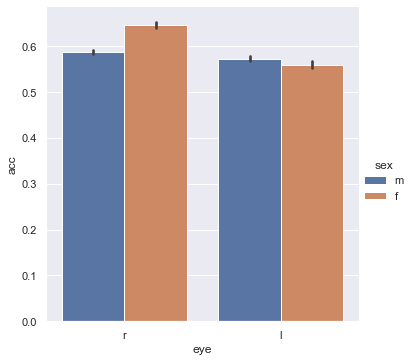

In [72]:
sns.catplot(x="eye", y="acc", hue="sex", data=clean_data, kind="bar")

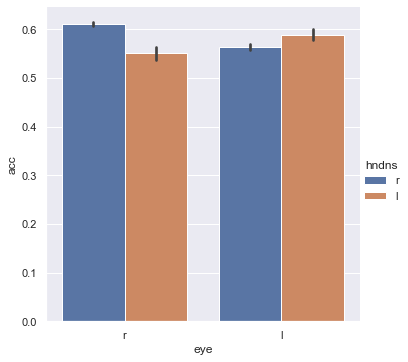

In [73]:
sns.catplot(x="eye", y="acc", hue="hndns", data=clean_data, kind="bar")

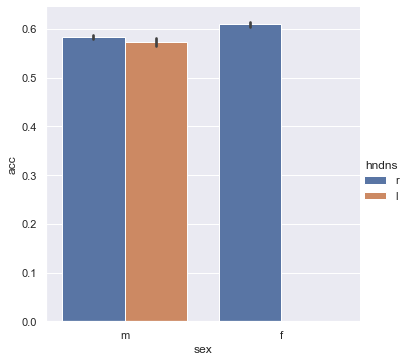

In [74]:
sns.catplot(x="sex", y="acc", hue="hndns", data=clean_data, kind="bar")

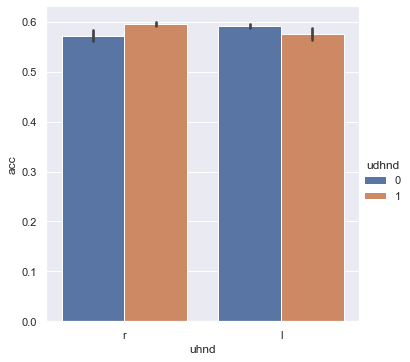

In [75]:
sns.catplot(x="uhnd", y="acc", hue="udhnd", data=clean_data, kind="bar")

# 4. Psychometric Fitting

In [76]:
data4 = data4.replace({'uhnd':{'r':0, 'l':1}, 'hndns':{'r':0, 'l':1}, 'eye':{'r':0, 'l':1}, 'sex':{'m':0, 'f':1},'stm':{'0.bmp':0, '10.bmp':2, '20.bmp':2, '30.bmp':3, '40.bmp':4, '50.bmp':5, '60.bmp':6, '70.bmp':7, '80.bmp':8} })
data4.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,lrt
3,8101004202,5,925.6644,o,10.0,0,0,0,0,22.0,2.0,6.830512
5,8101004202,7,1163.9952,o,6.0,0,0,0,0,22.0,2.0,7.059614
6,8101004202,5,1023.1118,o,9.0,0,0,0,0,22.0,2.0,6.930604
8,8101004202,8,970.4250,o,10.0,0,0,0,0,22.0,2.0,6.877734
14,8101004202,6,1175.1443,p,13.0,0,0,0,0,22.0,2.0,7.069146


In [77]:
data4['choice'] = data4.key.apply(lambda x : 1 if x in ['q', 'o'] else 0)

In [78]:
data4['vf'] = 0
data4.loc[(data4.pos.isin([2, 8, 13])), 'vf'] = 1
data4.loc[(data4.pos.isin([3, 4, 9])), 'vf'] = 2
data4.loc[(data4.pos.isin([5, 10, 11])), 'vf'] = 3
data4.loc[(data4.pos.isin([6, 7, 12])), 'vf'] = 4

In [79]:
data4['ecc'] = 0
data4.loc[((data4.pos< 8) & (data4.pos >1)), 'ecc'] = 1
data4.loc[((data4.pos< 14) & (data4.pos >7)), 'ecc'] = 2

In [80]:
data4 = pd.get_dummies(data4, columns = ['pos', 'vf', 'ecc'])

In [81]:
data4.columns

Index(['sbj', 'stm', 'rt', 'key', 'uhnd', 'hndns', 'eye', 'sex', 'age', 'edu',
       'lrt', 'choice', 'pos_1.0', 'pos_2.0', 'pos_3.0', 'pos_4.0', 'pos_5.0',
       'pos_6.0', 'pos_7.0', 'pos_8.0', 'pos_9.0', 'pos_10.0', 'pos_11.0',
       'pos_12.0', 'pos_13.0', 'vf_0', 'vf_1', 'vf_2', 'vf_3', 'vf_4', 'ecc_0',
       'ecc_1', 'ecc_2'],
      dtype='object')

In [82]:
data4

,sbj,stm,rt,key,uhnd,hndns,eye,sex,age,edu,...,pos_12.0,pos_13.0,vf_0,vf_1,vf_2,vf_3,vf_4,ecc_0,ecc_1,ecc_2
3,8101004202,5,925.664400,o,0,0,0,0,22.0,2.0,...,0,0,0,0,0,1,0,0,0,1
5,8101004202,7,1163.995200,o,0,0,0,0,22.0,2.0,...,0,0,0,0,0,0,1,0,1,0
6,8101004202,5,1023.111800,o,0,0,0,0,22.0,2.0,...,0,0,0,0,1,0,0,0,0,1
8,8101004202,8,970.425000,o,0,0,0,0,22.0,2.0,...,0,0,0,0,0,1,0,0,0,1
14,8101004202,6,1175.144300,p,0,0,0,0,22.0,2.0,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121690,8101000632,5,454.452038,w,1,0,0,0,28.0,2.0,...,0,1,0,1,0,0,0,0,0,1
121691,8101000632,7,345.216036,q,1,0,0,0,28.0,2.0,...,0,0,1,0,0,0,0,1,0,0
121692,8101000632,0,395.338058,w,1,0,0,0,28.0,2.0,...,0,0,0,0,0,1,0,0,0,1
121693,8101000632,7,416.251898,q,1,0,0,0,28.0,2.0,...,0,0,0,0,0,0,1,0,1,0


In [83]:
def get_pse(model, x):
    pred_probs = [i[1] for i in  model.predict_proba(x)]
    index=-1
    if [ i[0] for i in enumerate(pred_probs) if i[1]>0.5 ] !=[]:
        index = [ i[0] for i in enumerate(pred_probs) if i[1]>0.5 ][0]
    return x[index][0]

In [84]:
from sklearn.linear_model import LogisticRegression
probs = []
df = {'sbj':[], 'pos':[], 'vf':[], 'ecc':[], 'pse_pos':[],'pse_vf':[], 'pse_ecc':[] }
x = [[80/(i+1),1] for i in range(90, 9 , -1)]
plt.figure(figsize = (15,10))
for sbj in data4.sbj.unique():
    for i in range(1, 14):
        X, y = data4[data4.sbj == sbj][['stm','pos_'+str(i)+'.0']].values, data4[data4.sbj == sbj]['choice']
        clf = LogisticRegression(random_state=0).fit(X, y)
        pse = get_pse(clf, x)
        df['sbj'].append(sbj)
        df['pos'].append(i)
        df['vf'].append(np.nan)
        df['ecc'].append(np.nan)
        df['pse_pos'].append(pse*10)
        df['pse_vf'].append(np.nan)
        df['pse_ecc'].append(np.nan)
        plt.plot(  [i[1] for i in  clf.predict_proba(x)], marker = '.', linestyle='solid', label = 'pos'+str(i))
    plt.axhline(y=0.5, color='r', linestyle='-', linewidth=2)
    plt.xlabel('morphing value')
    plt.ylabel('probability of female response')
    plt.title('PSE for different locations for subject ' + sbj)
    plt.ylim([0,1])
    plt.legend()
    plt.savefig('pse_loc/'+sbj +'.png', dpi=300, bbox_inches='tight')
    plt.clf();

<Figure size 1080x720 with 0 Axes>

In [85]:
len(range(90, 9 , -1))

81

In [86]:
from sklearn.linear_model import LogisticRegression
probs = []
x = [[80/(i+1),1] for i in range(90, 9 , -1)]
plt.figure(figsize = (15,10))
for sbj in data4.sbj.unique():
    for i in range(0, 5):
        X, y = data4[data4.sbj == sbj][['stm','vf_'+str(i)]].values, data4[data4.sbj == sbj]['choice']
        clf = LogisticRegression(random_state=0).fit(X, y)
        plt.plot(  [i[1] for i in  clf.predict_proba(x)], marker = '.', linestyle='solid', label = 'vf_'+str(i))
        pse = get_pse(clf, x)
        df['sbj'].append(sbj)
        df['pos'].append(np.nan)
        df['vf'].append(i)
        df['ecc'].append(np.nan)
        df['pse_pos'].append(np.nan)
        df['pse_vf'].append(pse*10)
        df['pse_ecc'].append(np.nan)
    plt.axhline(y=0.5, color='r', linestyle='-', linewidth=2)
    plt.xlabel('morphing value')
    plt.ylabel('probability of female response')
    plt.title('PSE for different visual fields for subject ' + sbj)
    plt.ylim([0,1])
    plt.legend()
    plt.savefig('pse_vf/'+sbj +'.png', dpi=300, bbox_inches='tight')
    plt.clf();

<Figure size 1080x720 with 0 Axes>

In [87]:
from sklearn.linear_model import LogisticRegression
probs = []
x = [[80/(i+1),1] for i in range(90, 9 , -1)]
plt.figure(figsize = (15,10))
for sbj in data4.sbj.unique():
    for i in range(0, 3):
        X, y = data4[data4.sbj == sbj][['stm','ecc_'+str(i)]].values, data4[data4.sbj == sbj]['choice']
        clf = LogisticRegression(random_state=0).fit(X, y)
        plt.plot(  [i[1] for i in  clf.predict_proba(x)], marker = '.', linestyle='solid', label = 'ecc_'+str(i))
        pse = get_pse(clf, x)
        df['sbj'].append(sbj)
        df['pos'].append(np.nan)
        df['vf'].append(np.nan)
        df['ecc'].append(i)
        df['pse_pos'].append(np.nan)
        df['pse_vf'].append(np.nan)
        df['pse_ecc'].append(pse*10)
    plt.axhline(y=0.5, color='r', linestyle='-', linewidth=2)
    plt.xlabel('morphing value')
    plt.ylabel('probability of female response')
    plt.title('PSE for different Eccentricity for subject ' + sbj)
    plt.ylim([0,1])
    plt.legend()
    plt.savefig('pse_ecc/'+sbj +'.png', dpi=300, bbox_inches='tight')
    plt.clf();

<Figure size 1080x720 with 0 Axes>

In [88]:
pse_df = pd.DataFrame(df)
pse_df.head()

,sbj,pos,vf,ecc,pse_pos,pse_vf,pse_ecc
0,8101004202,1.0,NaN,NaN,72.727273,NaN,NaN
1,8101004202,2.0,NaN,NaN,72.727273,NaN,NaN
2,8101004202,3.0,NaN,NaN,72.727273,NaN,NaN
3,8101004202,4.0,NaN,NaN,57.142857,NaN,NaN
4,8101004202,5.0,NaN,NaN,8.791209,NaN,NaN


In [89]:
pse_loc = pse_df[~pse_df.pos.isna()]
model = ols('pse_pos ~ C(pos)', data=pse_loc).fit()
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table)

                 sum_sq     df         F    PR(>F)
C(pos)     21387.039020   12.0  3.647814  0.000023
Residual  406499.502002  832.0       NaN       NaN


In [90]:
pse_vf = pse_df[~pse_df.vf.isna()]
model = ols('pse_vf ~ C(vf)', data=pse_vf).fit()
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table)

                 sum_sq     df         F    PR(>F)
C(vf)       5126.129265    4.0  2.990816  0.019051
Residual  137116.554085  320.0       NaN       NaN


In [91]:
pse_ecc = pse_df[~pse_df.ecc.isna()]
model = ols('pse_ecc ~ C(ecc)', data=pse_ecc).fit()
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table)

                sum_sq     df        F    PR(>F)
C(ecc)     1358.428874    2.0  2.00557  0.137393
Residual  65023.486507  192.0      NaN       NaN


In [92]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [93]:
pse_loc

,sbj,pos,vf,ecc,pse_pos,pse_vf,pse_ecc
0,8101004202,1.0,NaN,NaN,72.727273,NaN,NaN
1,8101004202,2.0,NaN,NaN,72.727273,NaN,NaN
2,8101004202,3.0,NaN,NaN,72.727273,NaN,NaN
3,8101004202,4.0,NaN,NaN,57.142857,NaN,NaN
4,8101004202,5.0,NaN,NaN,8.791209,NaN,NaN
...,...,...,...,...,...,...,...
840,8101000632,9.0,NaN,NaN,72.727273,NaN,NaN
841,8101000632,10.0,NaN,NaN,8.791209,NaN,NaN
842,8101000632,11.0,NaN,NaN,72.727273,NaN,NaN
843,8101000632,12.0,NaN,NaN,8.791209,NaN,NaN


In [94]:
pos_means = {}
pos_intervals = {}
for pos in pse_loc.pos.unique():
    # Draw 300 bootstrap replicates
    data = pse_loc[pse_loc.pos == pos]['pse_pos']
    bs_replicates_pos = draw_bs_replicates(data,np.mean,1500)
    pos_means[str(pos)]= np.mean(bs_replicates_pos)
    pos_intervals[str(pos)] = np.percentile(bs_replicates_pos,[2.5,97.5])


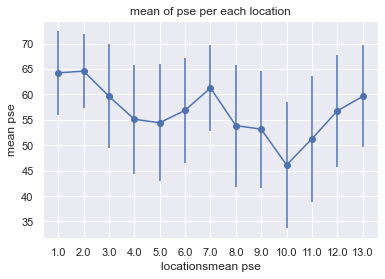

In [95]:
fig, ax = plt.subplots()
fig = plt.gcf()
ax.errorbar( pos_means.keys(), pos_means.values(),
            yerr=[i[1] - i[0] for i in pos_intervals.values()],
            fmt='-o')
ax.set_xlabel('locationsmean pse')
ax.set_ylabel('mean pse')
ax.set_title('mean of pse per each location')

plt.show()

In [96]:
vf_means = {}
vf_intervals = {}
for vf in pse_vf.vf.unique():
    # Draw 300 bootstrap replicates
    data = pse_vf[pse_vf.vf == vf]['pse_vf']
    bs_replicates_vf = draw_bs_replicates(data,np.mean,1500)
    vf_means[str(vf)]= np.mean(bs_replicates_vf)
    vf_intervals[str(vf)] = np.percentile(bs_replicates_vf,[2.5,97.5])


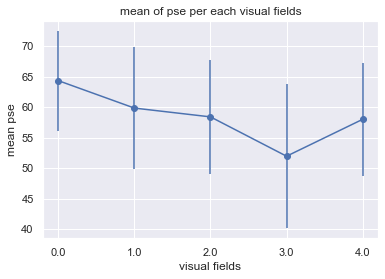

In [97]:
fig, ax = plt.subplots()
fig = plt.gcf()
ax.errorbar( vf_means.keys(), vf_means.values(),
            yerr=[i[1] - i[0] for i in vf_intervals.values()],
            fmt='-o')
ax.set_xlabel('visual fields')
ax.set_ylabel('mean pse')
ax.set_title('mean of pse per each visual fields')

plt.show()

In [98]:
ecc_means = {}
ecc_intervals = {}
for ecc in pse_ecc.ecc.unique():
    # Draw 300 bootstrap replicates
    data = pse_ecc[pse_ecc.ecc == ecc]['pse_ecc']
    bs_replicates_ecc = draw_bs_replicates(data,np.mean,1500)
    ecc_means[str(ecc)]= np.mean(bs_replicates_ecc)
    ecc_intervals[str(ecc)] = np.percentile(bs_replicates_ecc,[2.5,97.5])


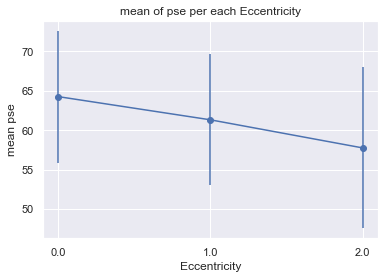

In [99]:
fig, ax = plt.subplots()
fig = plt.gcf()
ax.errorbar( ecc_means.keys(), ecc_means.values(),
            yerr=[i[1] - i[0] for i in ecc_intervals.values()],
            fmt='-o')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('mean pse')
ax.set_title('mean of pse per each Eccentricity')

plt.show()

# 5. Spread of PSEs

In [100]:
pse_df['ecc'] = 0
pse_df.loc[((pse_df.pos< 8) & (pse_df.pos >1)), 'ecc'] = 1
pse_df.loc[((pse_df.pos< 14) & (pse_df.pos >7)), 'ecc'] = 2

In [101]:
pse_df['vf'] = 0
pse_df.loc[(pse_df.pos.isin([2, 8, 13])), 'vf'] = 1
pse_df.loc[(pse_df.pos.isin([3, 4, 9])), 'vf'] = 2
pse_df.loc[(pse_df.pos.isin([5, 10, 11])), 'vf'] = 3
pse_df.loc[(pse_df.pos.isin([6, 7, 12])), 'vf'] = 4

In [102]:
pse_loc = pse_df[~pse_df.pos.isna()]
pse_loc.head()

,sbj,pos,vf,ecc,pse_pos,pse_vf,pse_ecc
0,8101004202,1.0,0,0,72.727273,NaN,NaN
1,8101004202,2.0,1,1,72.727273,NaN,NaN
2,8101004202,3.0,2,1,72.727273,NaN,NaN
3,8101004202,4.0,2,1,57.142857,NaN,NaN
4,8101004202,5.0,3,1,8.791209,NaN,NaN


In [103]:
vf_htrgn = {'vf':[],'pse_std':[]}
for sbj in pse_loc.sbj.unique():
    data = pse_loc[pse_loc.sbj == sbj]
    for vf in pse_loc.vf.unique():
        vf_htrgn['pse_std'].append(np.std(data[data.vf==vf]['pse_pos'].values))
        vf_htrgn['vf'].append(vf)
        
vf_htrgn_df = pd.DataFrame(vf_htrgn)
model = ols('pse_std ~ C(vf)', data=vf_htrgn_df).fit()
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table)

                sum_sq     df         F        PR(>F)
C(vf)      4497.789445    4.0  13.35816  4.449534e-10
Residual  26936.581250  320.0       NaN           NaN


In [104]:
ecc_htrgn = {'ecc':[],'pse_std':[]}
for sbj in pse_loc.sbj.unique():
    data = pse_loc[pse_loc.sbj == sbj]
    for ecc in pse_loc.ecc.unique():
        ecc_htrgn['pse_std'].append(np.std(data[data.ecc==ecc]['pse_pos'].values))
        ecc_htrgn['ecc'].append(ecc)
        
ecc_htrgn_df = pd.DataFrame(ecc_htrgn)
model = ols('pse_std ~ C(ecc)', data=ecc_htrgn_df).fit()
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table)

                sum_sq     df          F        PR(>F)
C(ecc)     7742.546316    2.0  52.622885  5.995321e-19
Residual  14124.737710  192.0        NaN           NaN


# 6. Reaction Time Correlation to Choice Complexity

In [105]:
clean_data['hrdns'] = clean_data.stm.apply(lambda x: np.abs(40 - np.abs(40 -int(x.split('.')[0]))))
clean_data.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,lrt,acc,ecc,vf,udhnd,hrdns
0,8101004202,50.bmp,925.6644,o,10.0,r,r,r,m,22.0,2.0,6.830512,1,2,3,1,30
1,8101004202,70.bmp,1163.9952,o,6.0,r,r,r,m,22.0,2.0,7.059614,1,1,4,1,10
2,8101004202,50.bmp,1023.1118,o,9.0,r,r,r,m,22.0,2.0,6.930604,1,2,2,1,30
3,8101004202,80.bmp,970.4250,o,10.0,r,r,r,m,22.0,2.0,6.877734,1,2,3,1,0
4,8101004202,60.bmp,1175.1443,p,13.0,r,r,r,m,22.0,2.0,7.069146,0,2,1,1,20


In [106]:
model = ols('rt ~ C(hrdns)', data=clean_data).fit()
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table)

                sum_sq       df         F    PR(>F)
C(hrdns)  5.545910e+05      3.0  3.878542  0.008744
Residual  4.678285e+09  98153.0       NaN       NaN


# 7.Representational Similarity Analysis (RSA)

In [107]:
pse_loc

,sbj,pos,vf,ecc,pse_pos,pse_vf,pse_ecc
0,8101004202,1.0,0,0,72.727273,NaN,NaN
1,8101004202,2.0,1,1,72.727273,NaN,NaN
2,8101004202,3.0,2,1,72.727273,NaN,NaN
3,8101004202,4.0,2,1,57.142857,NaN,NaN
4,8101004202,5.0,3,1,8.791209,NaN,NaN
...,...,...,...,...,...,...,...
840,8101000632,9.0,2,2,72.727273,NaN,NaN
841,8101000632,10.0,3,2,8.791209,NaN,NaN
842,8101000632,11.0,3,2,72.727273,NaN,NaN
843,8101000632,12.0,4,2,8.791209,NaN,NaN


C:\dev\python38\lib\site-packages\seaborn\matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


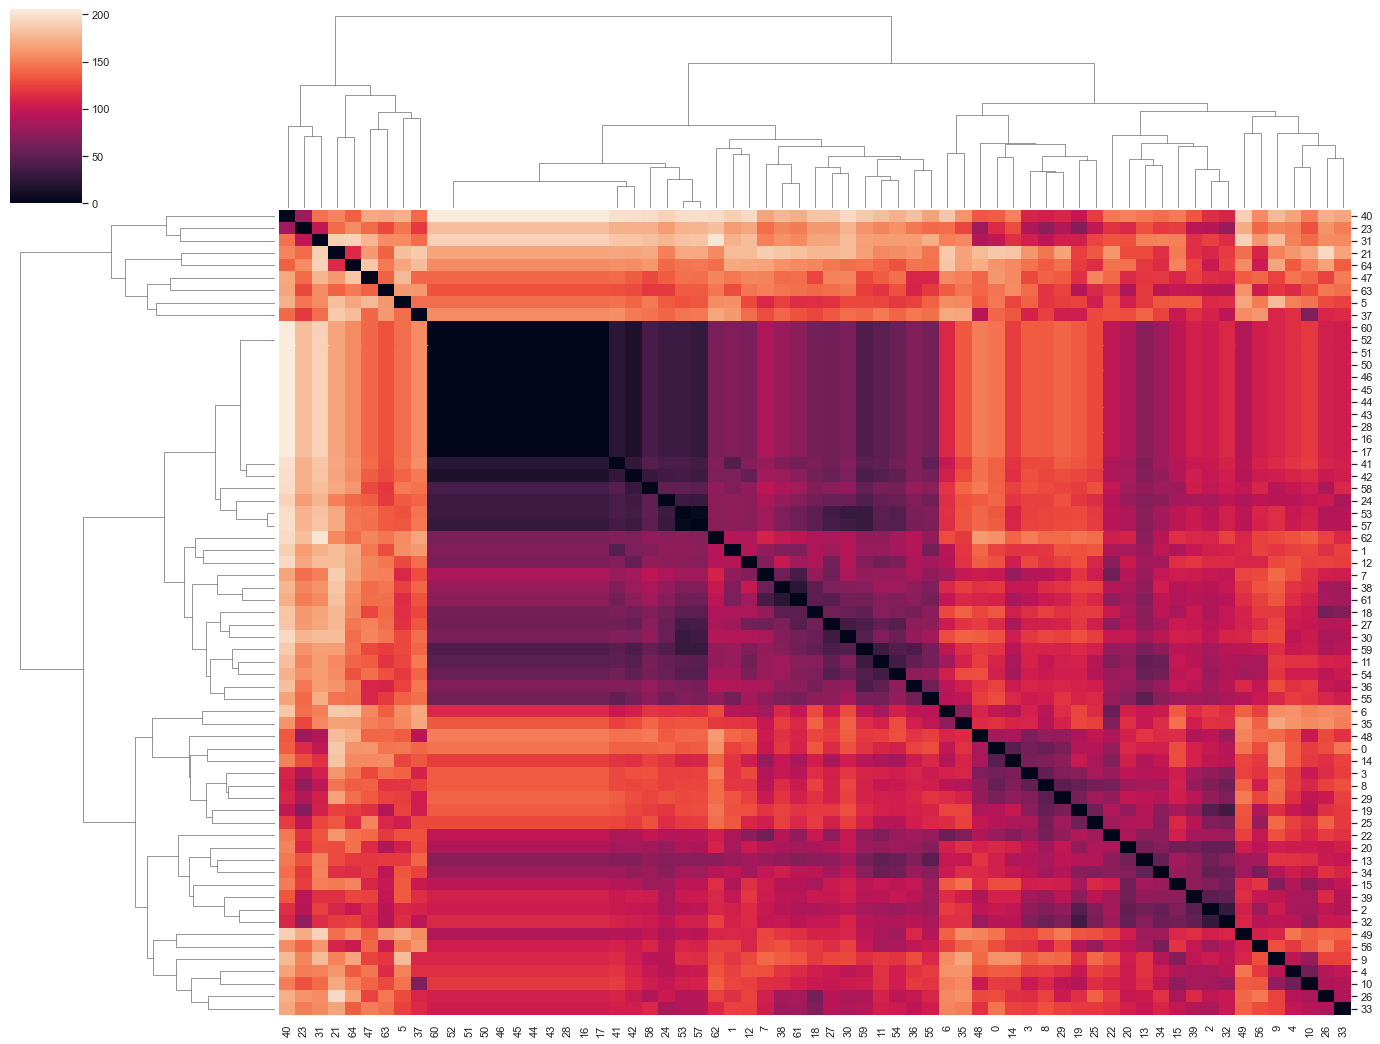

In [108]:
rda_dict = {}
for sbj in pse_loc.sbj.unique():
    rda_dict[sbj] = pse_loc[pse_loc.sbj == sbj].pse_pos.values
dim = len(list(rda_dict.keys()))
rsa_matrix = np.zeros((dim,dim))
pse_vecs = list(rda_dict.values())
for row in range(dim):
    for col in range(dim):
        rsa_matrix[row][col] = np.linalg.norm(pse_vecs[row] - pse_vecs[col])

g = sns.clustermap(rsa_matrix, yticklabels=1, xticklabels=1)
g.fig.set_figwidth(20)
g.fig.set_figheight(15)

In [234]:
cl1_loc = [42, 23, 31, 21, 64, 47, 63, 5, 37]
cl2_loc = [i for i in range(65) if i not in cl1_loc]
cl1_loc_sbj = [list(rda_dict.keys())[i] for i in cl1_loc]
cl2_loc_sbj = [list(rda_dict.keys())[i] for i in cl2_loc]

In [235]:
data4['cluster_loc'] = data4['sbj'].apply(lambda x : 1 if x in cl2_loc_sbj else 0)

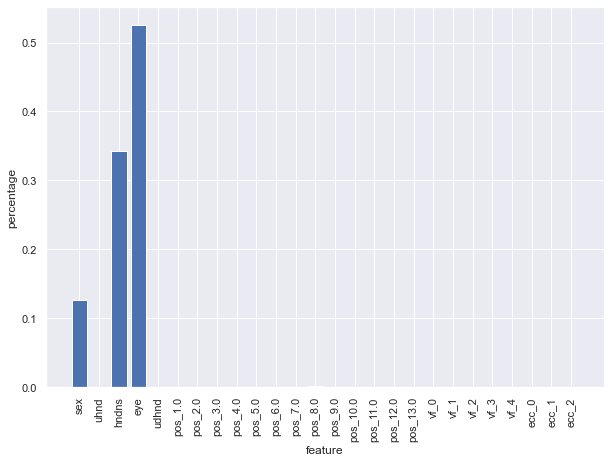

In [236]:
from sklearn.tree import DecisionTreeRegressor
params = ['sex','uhnd','hndns','eye','udhnd','pos_1.0','pos_2.0','pos_3.0','pos_4.0','pos_5.0','pos_6.0','pos_7.0','pos_8.0','pos_9.0','pos_10.0','pos_11.0','pos_12.0','pos_13.0',
          'vf_0','vf_1','vf_2','vf_3','vf_4','ecc_0','ecc_1','ecc_2'] 
model = DecisionTreeRegressor() 
# fit the model 
model.fit(data4[params], np.array(data4['cluster_loc']))
importance = model.feature_importances_
plt.figure(figsize=(10, 7))
plt.bar(params, importance)
plt.xlabel('feature')
plt.ylabel('percentage')
plt.xticks(rotation=90);

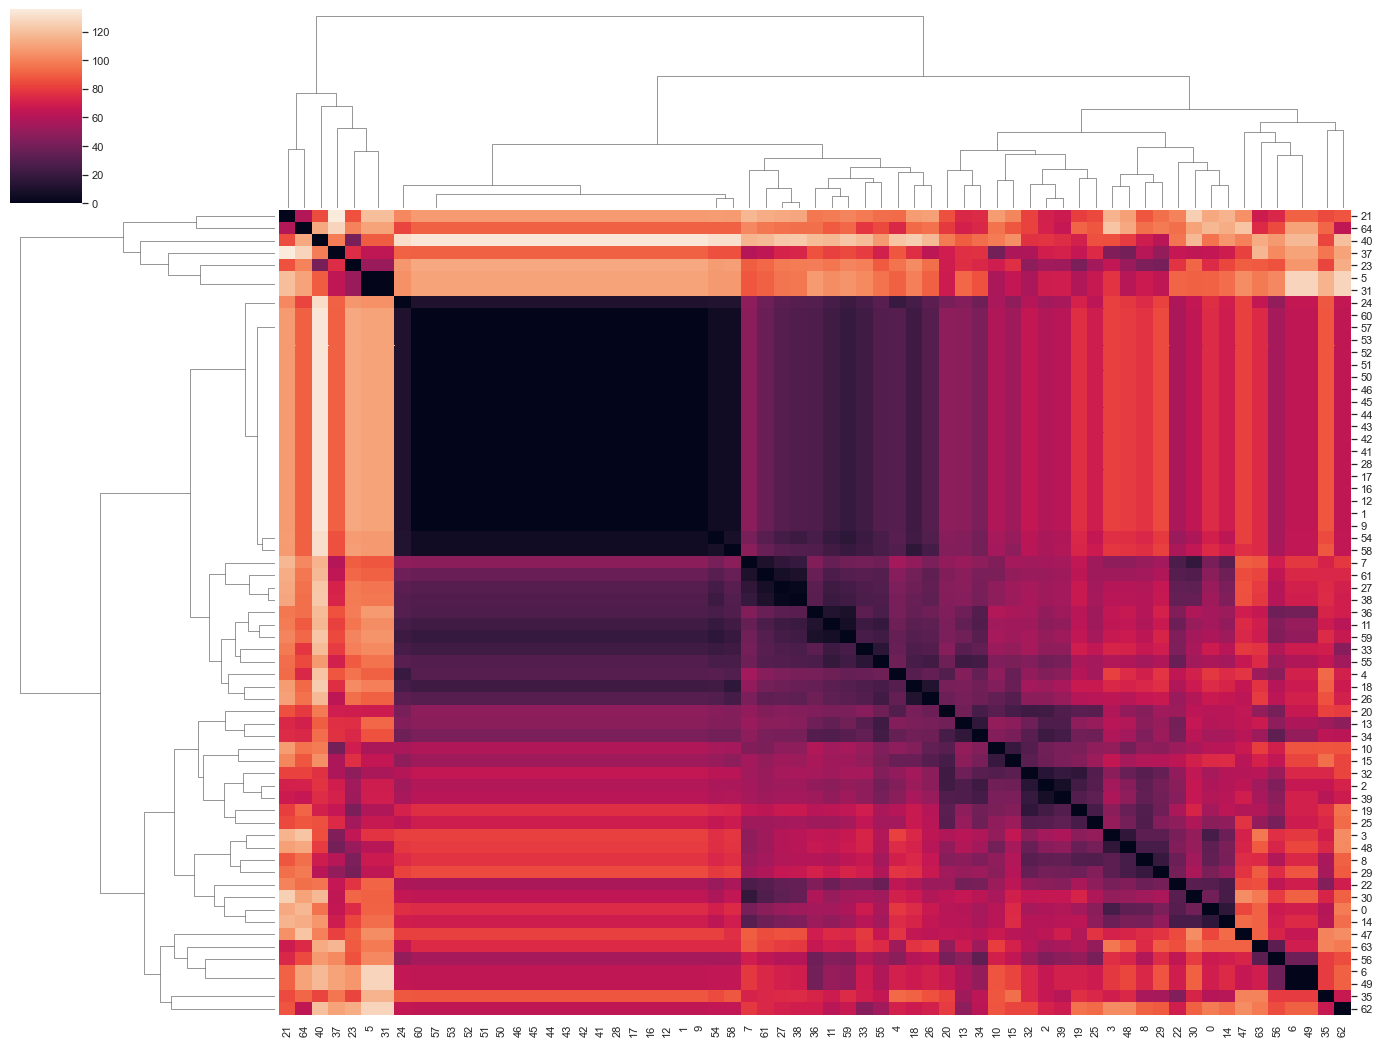

In [109]:
rda_vf_dict = {}
for sbj in pse_vf.sbj.unique():
    rda_vf_dict[sbj] = pse_vf[pse_vf.sbj == sbj].pse_vf.values
dim = len(list(rda_vf_dict.keys()))
rsa_vf_matrix = np.zeros((dim,dim))
pse_vecs = list(rda_vf_dict.values())
for row in range(dim):
    for col in range(dim):
        rsa_vf_matrix[row][col] = np.linalg.norm(pse_vecs[row] - pse_vecs[col])

g = sns.clustermap(rsa_vf_matrix, yticklabels=1, xticklabels=1)
g.fig.set_figwidth(20)
g.fig.set_figheight(15)

In [214]:
cl1_vf = [21, 64, 40, 37, 23, 5, 31]
cl2_vf = [i for i in range(65) if i not in cl1_vf]
cl1_vf_sbj = [list(rda_dict.keys())[i] for i in cl1_vf]
cl2_vf_sbj = [list(rda_dict.keys())[i] for i in cl2_vf]

In [216]:
data4['udhnd'] = data4[['uhnd','hndns']].apply(lambda x: 1 if x.uhnd == x.hndns else 0, axis=1)
data4['cluster_vf'] = data4['sbj'].apply(lambda x : 1 if x in cl2_vf_sbj else 0)

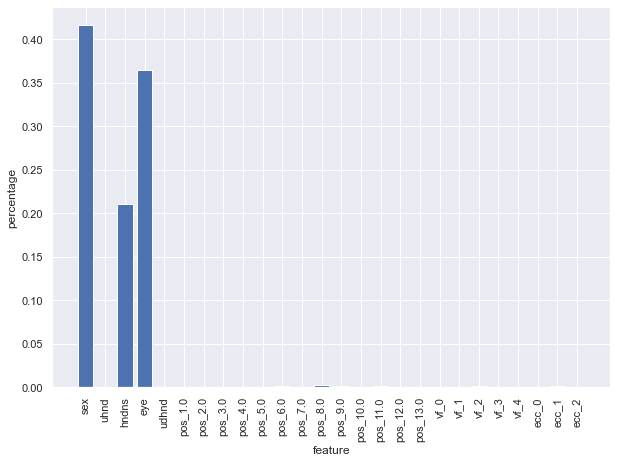

In [229]:
from sklearn.tree import DecisionTreeRegressor
params = ['sex','uhnd','hndns','eye','udhnd','pos_1.0','pos_2.0','pos_3.0','pos_4.0','pos_5.0','pos_6.0','pos_7.0','pos_8.0','pos_9.0','pos_10.0','pos_11.0','pos_12.0','pos_13.0',
          'vf_0','vf_1','vf_2','vf_3','vf_4','ecc_0','ecc_1','ecc_2'] 
model = DecisionTreeRegressor() 
# fit the model 
model.fit(data4[params], np.array(data4['cluster_vf']))
importance = model.feature_importances_
plt.figure(figsize=(10, 7))
plt.bar(params, importance)
plt.xlabel('feature')
plt.ylabel('percentage')
plt.xticks(rotation=90);

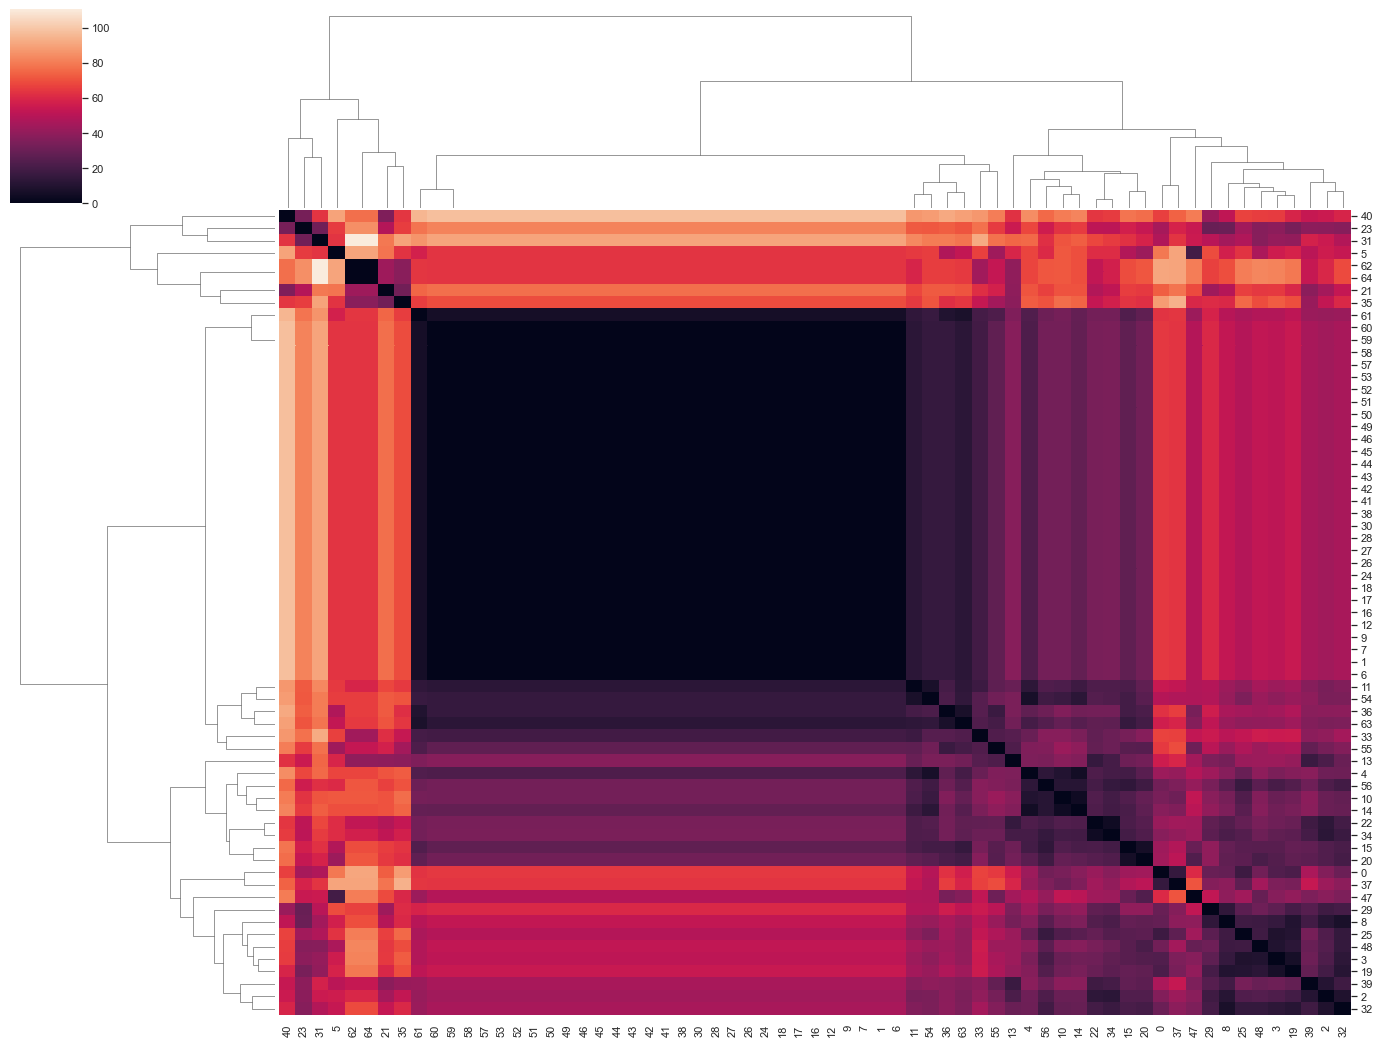

In [110]:
rda_ecc_dict = {}
for sbj in pse_ecc.sbj.unique():
    rda_ecc_dict[sbj] = pse_ecc[pse_ecc.sbj == sbj].pse_ecc.values
dim = len(list(rda_ecc_dict.keys()))
rsa_ecc_matrix = np.zeros((dim,dim))
pse_vecs = list(rda_ecc_dict.values())
for row in range(dim):
    for col in range(dim):
        rsa_ecc_matrix[row][col] = np.linalg.norm(pse_vecs[row] - pse_vecs[col])

g = sns.clustermap(rsa_ecc_matrix, yticklabels=1, xticklabels=1)
g.fig.set_figwidth(20)
g.fig.set_figheight(15)

In [231]:
cl1_ecc = [40, 23, 31, 5, 62, 64, 21, 35]
cl2_ecc = [i for i in range(65) if i not in cl1_ecc]
cl1_ecc_sbj = [list(rda_dict.keys())[i] for i in cl1_ecc]
cl2_ecc_sbj = [list(rda_dict.keys())[i] for i in cl2_ecc]

In [232]:
data4['cluster_ecc'] = data4['sbj'].apply(lambda x : 1 if x in cl2_ecc_sbj else 0)

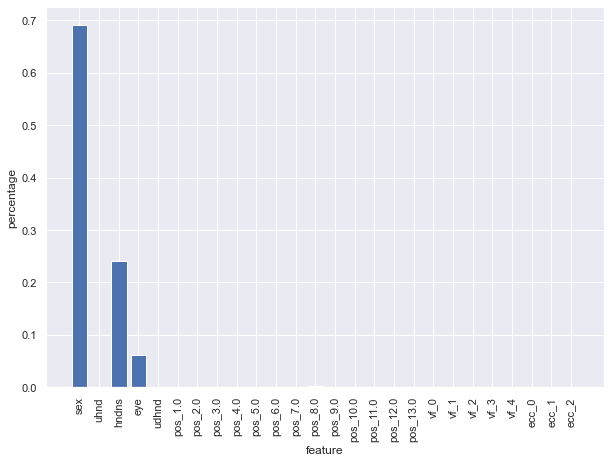

In [233]:
from sklearn.tree import DecisionTreeRegressor
params = ['sex','uhnd','hndns','eye','udhnd','pos_1.0','pos_2.0','pos_3.0','pos_4.0','pos_5.0','pos_6.0','pos_7.0','pos_8.0','pos_9.0','pos_10.0','pos_11.0','pos_12.0','pos_13.0',
          'vf_0','vf_1','vf_2','vf_3','vf_4','ecc_0','ecc_1','ecc_2'] 
model = DecisionTreeRegressor() 
# fit the model 
model.fit(data4[params], np.array(data4['cluster_ecc']))
importance = model.feature_importances_
plt.figure(figsize=(10, 7))
plt.bar(params, importance)
plt.xlabel('feature')
plt.ylabel('percentage')
plt.xticks(rotation=90);